In [1]:
%%HTML
<style>.container{width:100%;}</style>

Dieses Notebook hängt vom Notebook `Ordered-Sets` ab. Es hängt auch von Dateien im Ordner `Aux` ab, die aus [diesen Vorlesungsunterlagen](https://github.com/karlstroetmann/Logic/tree/master/Python "K. Stroetmann (2020): Logic/Python, GitHub") abgeleitet wurden; dem Notebook `N-Queens` und der Datei `davisPutnam.py`, wobei letztere von `N-Queens` importiert wird. Aus [diesen Vorlesungsunterlagen](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub") sind die Notebooks `Set` und `HashMap`, die auch hier verwendet werden.

Help on class set in module builtins:

class set(object)
 |  set() -> new empty set object
 |  set(iterable) -> new set object
 |  
 |  Build an unordered collection of unique elements.
 |  
 |  Methods defined here:
 |  
 |  __and__(self, value, /)
 |      Return self&value.
 |  
 |  __contains__(...)
 |      x.__contains__(y) <==> y in x.
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __gt__(self, value, /)
 |      Return self>value.
 |  
 |  __iand__(self, value, /)
 |      Return self&=value.
 |  
 |  __init__(self, /, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __ior__(self, value, /)
 |      Return self|=value.
 |  
 |  __isub__(self, value, /)
 |      Return self-=value.
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __ixor__(self, value, /)
 |      Re

Autosave disabled


andre


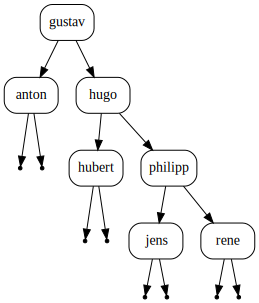

anton


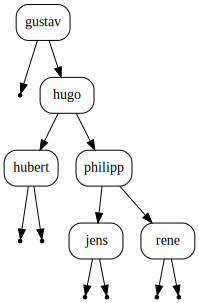

gustav


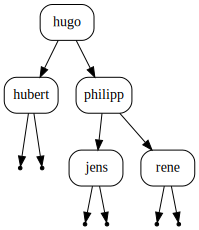

hubert


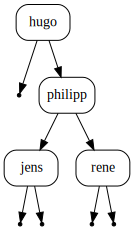

hugo


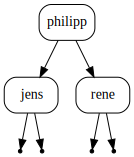

jens


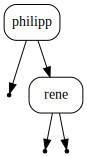

philipp


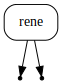

rene


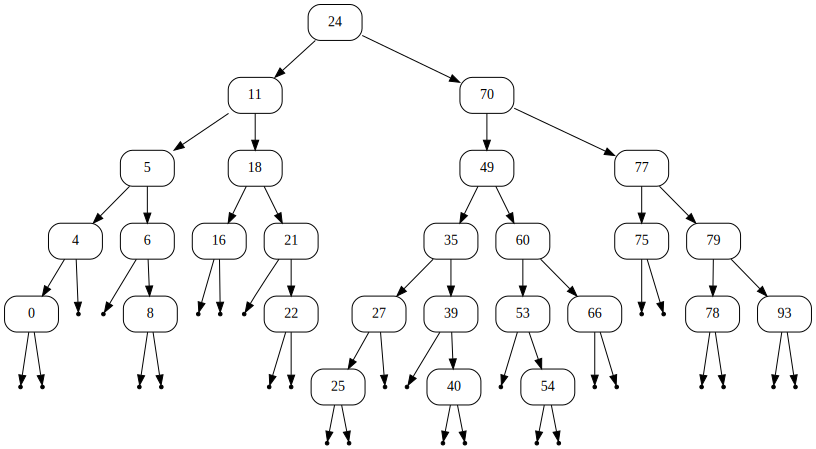

0 4 5 6 8 11 16 18 21 22 24 25 27 35 39 40 49 53 54 60 66 70 75 77 78 79 93 

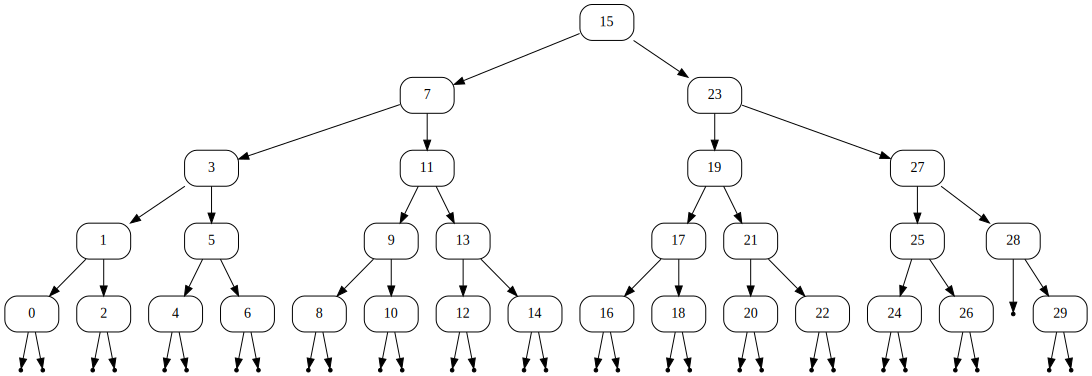

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

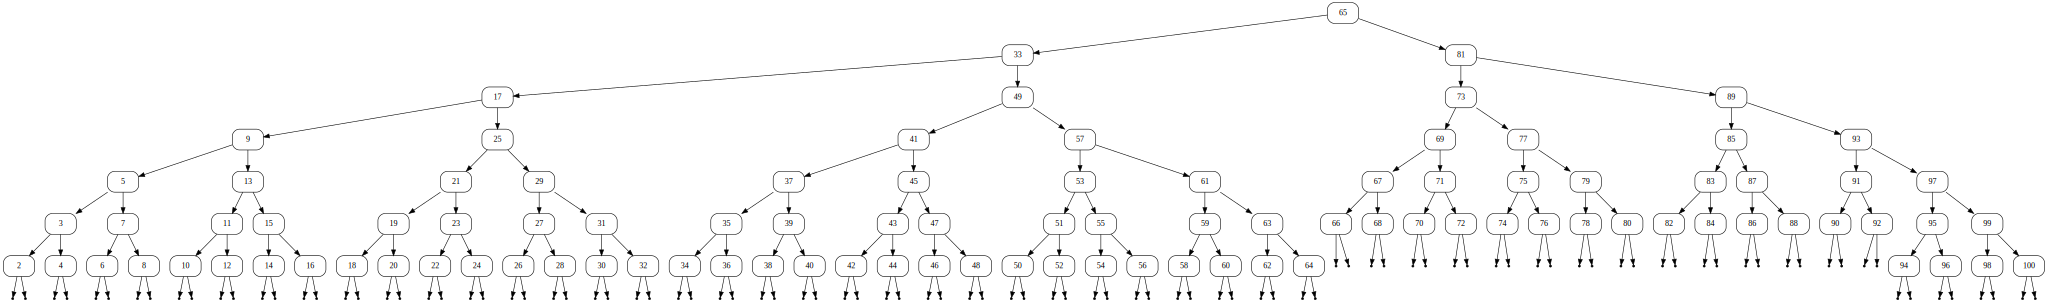

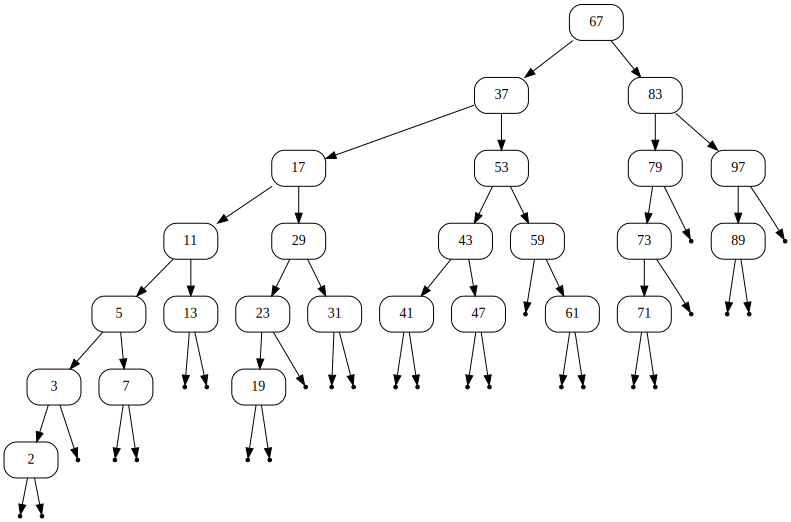

2 3 5 7 11 13 17 19 23 29 31 37 41 43 47 53 59 61 67 71 73 79 83 89 97 

Autosave disabled


mEntries = 6 mSize = 3
mEntries = 14 mSize = 7


In [2]:
%run Ordered-Sets.ipynb
%run Aux/Set.ipynb
%run Aux/HashMap.ipynb

Wir benötigen auch `deque` und `Counter` aus den zur Standard Library gehörenden `collections`.

In [3]:
from collections import deque, Counter

# Performance

## Vergleichsobjekte

Wir werden im Folgenden `OrderedSet` bzw. `OrderedFrozenset` nicht nur mit `set` bzw. `frozenset`, sondern auch mit der auf *AVL-Bäumen* basierenden Implementierung `Set` und der Hashtabellenimplementierung `HashTable` vergleichen. Letztere stammen von [Stroetmann](https://github.com/karlstroetmann/Algorithms/tree/master/Python "K. Stroetmann (2020): Algorithms/Python, GitHub"). Für diese müssen wir einige Methoden hinzufügen, die für unsere Tests benötigt werden, die aber nicht in diesen Implementierungen vorhanden sind.

### Erweiterung von `Set` (AVL-Bäume)

Wir erweitern `Set` dahingehend, dass eine Konstruktion aus einem Iterablen möglich ist. Da in Python keine Konstruktorpolymorphie erlaubt ist, überschreiben wir den Konstruktor von `Set`, wobei wir zunächst den Code des ursprünglichen Konstruktors übernehmen, und danach gegebenenfalls die Elemente einfügen.

In [4]:
def __init__(self, iterable=[]):
    self.mKey = None
    self.mLeft = None
    self.mRight = None
    self.mHeight = 0
    for el in iterable:
        self.insert(el)

Set.__init__ = __init__
del __init__

`discard`, das Entfernen, das auch für nicht vorhandene Elemente definiert ist, soll unterstützt werden. Wir setzen `discard` auf das vorhandene `delete`.

In [5]:
Set.discard = Set.delete

Die Funktionalität von `delete` ändern wir nicht; dies bedeutet, dass in den Tests nie eine Konstruktion wie diese hier verwendet werden darf:

```
try:
    some_set.remove(some_element)
except KeyError:
    ...
```

Anders gesagt: Die folgenden Performancetests dürfen nicht erwarten, dass beim Entfernen eines Elements aus einer Menge auch dann kein Fehler gehoben wird, wenn dieses Element nicht in der Menge vorhanden ist.

Um `Set`s ausgeben zu können, implementieren wir zunächst `__iter__` ähnlich wie beim `OrderedSet` in Form einer In-Order-Ausgabe.

In [6]:
def __iter__(self):
    stack = deque()
    tree = self
    while stack or tree is not None:
        if tree is not None:
            stack.append(tree)
            tree = tree.mLeft
            continue
        tree = stack.pop()
        if tree.mKey is not None:
            yield tree.mKey
        tree = tree.mRight

Set.__iter__ = __iter__
del __iter__

Zur eigentlichen Ausgabe implementieren wir ebenfalls ähnlich wie beim `OrderedSet`:

In [7]:
def __repr__(self):
    return f"{type(self).__name__}({list(self)})"

Set.__repr__ = __repr__
del __repr__

Zur Unterstützung von beliebigen Elementen geben wir `Set` die Methoden `_arb_lt`, `_arb_eq` und `_arb_gt` von `Node` und benutzen diese in den existierenden Methoden `member`, `insert` und `delete`.

In [8]:
Set._arb_lt = Node._arb_lt
Set._arb_eq = Node._arb_eq
Set._arb_gt = Node._arb_gt

def member(self, key):
    if self.isEmpty():
        return
    elif self._arb_eq(self.mKey, key):
        return True
    elif self._arb_lt(key, self.mKey):
        return self.mLeft.member(key)
    else:
        return self.mRight.member(key)

def insert(self, key):
    if self.isEmpty():
        self.mKey = key
        self.mLeft = Set()
        self.mRight = Set()
        self.mHeight = 1
    elif self._arb_eq(self.mKey, key):
        pass
    elif self._arb_lt(key, self.mKey):
        self.mLeft.insert(key)
        self._restore()
    else:
        self.mRight.insert(key)
        self._restore()

def delete(self, key):
    if self.isEmpty():
        return
    if self._arb_eq(key, self.mKey):
        if self.mLeft.isEmpty():
            self._update(self.mRight)
        elif self.mRight.isEmpty():
            self._update(self.mLeft)
        else:
            self.mRight, self.mKey = self.mRight._delMin()
    elif self._arb_lt(key, self.mKey):
        self.mLeft.delete(key)
    else:
        self.mRight.delete(key)

Set.member = member
Set.insert = insert
Set.delete = delete
del member, insert, delete

Zur Unterstützung von `Set`s von `Set`s müssen wir die Ordnungen `<` und `==` (`__lt__` und `__eq__`) zwischen `Set`s ermöglichen. Hier können wir die lexikographische Ordnung ähnlich wie bei `OrderedSet` implementieren. Wir verzichten auf das Anheben von `TypeError`s, wenn die Typen inkompatibel sind. Somit dürfen die Tests keine Konstruktion wie diese hier verwenden:

```
try:
    if some_set < some_mysterious_object:
        ...
except TypeError:
    ...
```

In [9]:
def __lt__(self, other):
    x_iter, y_iter = iter(self), iter(other)
    while True:
        try:
            y_item = next(y_iter)
        except StopIteration:
            return False
        try:
            x_item = next(x_iter)
        except StopIteration:
            return True
        if self._arb_lt(x_item, y_item):
            return True
        if self._arb_gt(x_item, y_item):
            return False

def __eq__(self, other):
    x_iter, y_iter = iter(self), iter(other)
    while True:
        try:
            x_item = next(x_iter)
        except StopIteration:
            try:
                next(y_iter)
            except StopIteration:
                return True
            return False
        try:
            y_item = next(y_iter)
        except StopIteration:
            return False
        if not self._arb_eq(x_item, y_item):
            return False

Set.__lt__ = __lt__
Set.__eq__ = __eq__
del __lt__, __eq__

Wir redefinieren `Set.isEmpty` und `Set.pop`, weil sie für den Vergleich mit `None` den Operator `==` statt `is` verwenden. Das funktioniert nicht mehr, wenn wir `Set.__eq__` gesetzt haben.

In [10]:
def isEmpty(self):
    return self.mKey is None

def pop(self):
    if self.mKey is None:
        raise KeyError
    if self.mLeft.mKey is None:
        key = self.mKey
        self._update(self.mRight)
        return key
    return self.mLeft.pop()

Set.isEmpty = isEmpty
Set.pop = pop
del isEmpty, pop

`copy`, `__sub__` (`-`) und `__or__` (`|`) implementieren wir ähnlich wie in `OrderedSet`, wieder ohne Typüberprüfung.

In [11]:
def copy(self):
    return type(self)(self)

def __sub__(self, other):
    difference = type(self)(self)
    for el in other:
        difference.discard(el)
    return difference

def __or__(self, other):
    intersection = type(self)(self)
    for el in other:
        intersection.insert(el)
    return intersection

Set.copy = copy
Set.__sub__ = __sub__
Set.__or__ = __or__
del copy, __sub__, __or__

`__len__` können wir von `OrderedSet` übernehmen.

In [12]:
Set.__len__ = OrderedSet.__len__

### Erweiterung von `HashTable`

Wir werden nicht `HashTable` direkt ansprechen, da diese Implementierung ein wichtiges Detail enthält, das wir bei der Verwendung der `HashTable`s als Menge nicht sichtbar haben wollen: Die Tabellen werden mit einer spezifizierten Größe konstruiert, und auf diese Funktion wird auch in den anderen Methoden von `HashTable` noch zugegriffen. Daher bauen wir die Klasse `HashSet`, die einen `HashTable` vorhält. Dieser wird anfangs mit der Defaultgröße 256 erstellt. Wir unterstützen die Konstruktion aus einem Iterablen. Der `HashTable` ist eigentlich ein Dictionary und keine Menge, somit speichern wir für jeden Schlüssel den Wert `True` ab.

In [13]:
class HashSet:
    def __init__(self, iterable=[]):
        self.set = HashTable(256)
        for el in iterable:
            self.set.insert(el, True)

Wir überschreiben für `HashTable` die Definition von `hash_code`, die nur mit Strings funktioniert, indem wir einfach `hash` aufrufen und den übergebenen Modul anwenden.

In [14]:
def hash_code(value, modulus):
    return hash(value) % modulus

Wir müssen eine Hashfunktion für die Mengen selbst definieren, damit Mengen von Mengen ermöglicht werden. Wir summieren dafür die Hashwerte aller Elemente auf und können dabei die Implementierung von `OrderedFrozenset` übernehmen.

In [15]:
HashSet.__hash__ = OrderedFrozenset.__hash__

Auch einen Gleichheitsbegriff für `HashSet`s benötigen wir. Wir überprüfen zunächst, ob die beiden Tabellen gleich lang sind, und überprüfen in diesem Fall alle Zellen mithilfe vom hash-basierten [`Counter`](https://docs.python.org/3.7/library/collections.html#collections.Counter "Python Software Foundation (2020): The Python Standard Library/Data Types/collections/Counter, Python Documentation") aus den `collections`.

In [16]:
def __eq__(self, other):
    if self.set.mSize != other.set.mSize:
        return False
    for cell_x, cell_y in zip(self.set.mArray, other.set.mArray):
        if Counter(cell_x) != Counter(cell_y):
            return False
    return True

HashSet.__eq__ = __eq__
del __eq__

Des weiteren rufen wir für `insert` und `discard` respektive die Methoden `insert` und `delete` auf. Die Verwendung von `insert` erleichtert die Wiederverwendung von Methoden von `Set`.

In [17]:
def insert(self, element):
    self.set.insert(element, True)

def discard(self, element):
    self.set.delete(element)

HashSet.insert = insert
HashSet.discard = discard
del insert, discard

Wir implementieren auch ein `__iter__` zur Stringdarstellung von `HashSet`s, wobei wir alle belegten Schlüssel anzeigen, und übernehmen `__repr__` von `Set`.

In [18]:
def __iter__(self):
    for cell in self.set.mArray:
        for el in cell:
            yield el[0]

HashSet.__iter__ = __iter__
del __iter__
HashSet.__repr__ = Set.__repr__

Ferner entfernen wir aus der Originalimplementierung von `HashTable` das `print`-Statement in `insert`, das hier nicht benötigt wird.

In [19]:
def insert(self, key, value):
    if self.mEntries >= self.mSize * self.mAlpha:
        self._rehash()
    index = hash_code(key, self.mSize)
    aList = self.mArray[index]
    for i, (k, v) in enumerate(aList):
        if k == key:
            aList[i] = (key, value)
            return
    self.mEntries += 1
    aList.append((key, value))

HashTable.insert = insert
del insert

Für `pop` entfernen wir das erstbeste Element aus dem Array.

In [20]:
def pop(self):
    for cell in self.set.mArray:
        if cell:
            el = cell.pop()[0]
            self.set.mEntries -= 1
            return el

HashSet.pop = pop
del pop

Die Implementierungen von `copy`, `__sub__` (`-`) und `__or__` (`|`) waren in `Set` so gehalten, dass wir sie jetzt wiederverwenden können.

In [21]:
HashSet.copy = Set.copy
HashSet.__sub__ = Set.__sub__
HashSet.__or__ = Set.__or__

Zuletzt benötigen wir `__len__` für die Länge, die schon vorgehalten wird.

In [22]:
def __len__(self):
    return self.set.mEntries

HashSet.__len__ = __len__
del __len__

## Anwendungsbeispiel: Sieb des Eratosthenes

Als Anwendungsbeispiel benutzen wir die zu testenden Mengen, um alle Primzahlen bis zu einem Maximum abzulegen. Die Primzahlen werden dabei mit dem Sieb des Eratosthenes berechnet. Die Implementierung ist sehr einfach gehalten und hat Raum für Optimierungen, aber das ist für den Vergleich untereinander unproblematisch. Wir schreiben die Funktion so, dass zur Laufzeit die Klasse, die für die Menge benutzt werden soll, übergeben werden kann.

In [23]:
def primes(n, TestSet):
    primes = TestSet(range(2, n + 1))
    for i in range(2, n + 1):
        for j in range(2 * i, n + 1, i):
            primes.discard(j)
    return primes

Wir berechnen probeweise die Primzahlen bis 100.

In [24]:
n = 100
print(f"           {primes(n, set)}")
print(f"{primes(n, OrderedSet)}")
print(f"       {primes(n, Set)}")
print(f"   {primes(n, HashSet)}")

           {2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97}
OrderedSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
       Set([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])
   HashSet([2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97])


Wir betrachten nun vergleichend die Ausführungszeiten der Varianten.

In [25]:
def fmt_against_splay(splay_time, other_time):
    if splay_time > other_time:
        return f"Splaying was {round(splay_time / other_time, 2)} times slower"
    else:
        return f"Splaying was {round(other_time / splay_time, 2)} times faster"

n = 10**4

# Ignore missing whitespace around operator because this is actually a flag
# Ignore syntax error that flake8 sees due to a compatibility issue
splay_times = %timeit -o primes(n, OrderedSet)  # noqa: E225, E999
splay_time = splay_times.best

set_times = %timeit -o primes(n, set)  # noqa: E225
set_time = set_times.best

avl_times = %timeit -o primes(n, Set)  # noqa: E225
avl_time = avl_times.best

hash_times = %timeit -o primes(n, HashSet)  # noqa: E225
hash_time = hash_times.best

print(f"Native sets: {fmt_against_splay(splay_time, set_time)}")
print(f"AVL sets: {fmt_against_splay(splay_time, avl_time)}")
print(f"Python hash maps: {fmt_against_splay(splay_time, hash_time)}")

505 ms ± 46.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.3 ms ± 760 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
709 ms ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
77.3 ms ± 408 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Native sets: Splaying was 42.87 times slower
AVL sets: Splaying was 1.57 times faster
Python hash maps: Splaying was 5.77 times slower


Dabei ist zu beachten, dass wir zu diesem Zeitpunkt im Fall der nativen `set`s die Python-Implementierung mit einer C-Implementierung vergleichen.

## Anwendungsbeispiel: $n$-Damen-Problem

In einem weiteren Anwendungsbeispiel benutzen wir die zu testenden Mengen, um den Algorithmus von Davis und Putnam zu implementieren, wobei die Implementierung an [Stroetmann](https://github.com/karlstroetmann/Logic/tree/master/Python "K. Stroetmann (2020): Logic/Python, GitHub") orientiert ist. Damit werden wir das $n$-Damen-Problem lösen, welches als aussagenlogisches Problem aufgefasst wird (Implementierung in der gleichen Quelle). Beim $n$-Damen-Problem ist das Ziel, $n$ Damen auf ein $n \times n$-Schachbrett zu platzieren, sodass keine Dame eine andere Dame gemäß den Regeln des Schachspiels bedroht.

Wir implementieren dafür zunächst alle Methoden des Algorithmus von Davis und Putnam. Dabei übernehmen wir die Implementierung aus dem Repository, geben allen Methoden aber die zu verwendenden Klassen für veränderliche und unveränderliche Mengen mit, und verwenden im Folgenden diese Klassen.

In [26]:
def complement(l, TestSet, TestFrozenset):
    if isinstance(l, str):
        return ('¬', l)
    else:
        return l[1]

def extractVariable(l, TestSet, TestFrozenset):
    if isinstance(l, str):
        return l
    else:
        return l[1]

def arb(S, TestSet, TestFrozenset):
    for x in S:
        return x

def selectVariable(Clauses, Forbidden, TestSet, TestFrozenset):
    returnable = arb(TestSet([extractVariable(L, TestSet, TestFrozenset)
                              for C in Clauses for L in C]) - Forbidden,
                     TestSet, TestFrozenset)
    return returnable

def reduce(Clauses, l, TestSet, TestFrozenset):
    lBar = complement(l, TestSet, TestFrozenset)
    return (TestSet([C - TestSet([lBar]) for C in Clauses if lBar in C])
            | TestSet([C for C in Clauses if lBar not in C and l not in C])
            | TestSet([TestFrozenset(TestSet([l]))]))

def saturate(Clauses, TestSet, TestFrozenset):
    S = Clauses.copy()
    Units = TestSet([C for C in S if len(C) == 1])
    Used = TestSet()
    while len(Units) > 0:
        unit = Units.pop()
        Used |= TestSet([unit])
        l = arb(unit, TestSet, TestFrozenset)  # noqa: E741
        S = reduce(S, l, TestSet, TestFrozenset)
        Units = TestSet([C for C in S if len(C) == 1]) - Used
    return S

def solve(Clauses, Variables, TestSet, TestFrozenset):
    S = saturate(Clauses, TestSet, TestFrozenset)
    empty = TestFrozenset()
    Falsum = TestSet([empty])
    if empty in S:
        return Falsum
    if all(len(C) == 1 for C in S):
        return S
    p = selectVariable(S, Variables, TestSet, TestFrozenset)
    negP = complement(p, TestSet, TestFrozenset)
    Result = solve(S | TestSet([TestFrozenset(TestSet([p]))]),
                   Variables | TestSet([p]), TestSet, TestFrozenset)
    if Result != Falsum:
        return Result
    return solve(S | TestSet([TestFrozenset(TestSet([negP]))]),
                 Variables | TestSet([p]), TestSet, TestFrozenset)

Auch reimplementieren wir die nötigen Methoden für die Spezifikation des $n$-Damen-Problems.

In [27]:
def var(row, col, TestSet, TestFrozenset):
    return "Q(" + str(row) + "," + str(col) + ")"

def atMostOne(S, TestSet, TestFrozenset):
    return TestSet([TestFrozenset(TestSet([("¬", p), ("¬", q)])) for p in S
                    for q in S
                    if p != q])

def atMostOneInRow(row, n, TestSet, TestFrozenset):
    return atMostOne(TestSet([var(row, col, TestSet, TestFrozenset)
                              for col in range(1, n + 1)]),
                     TestSet, TestFrozenset)

def oneInColumn(col, n, TestSet, TestFrozenset):
    return TestSet([TestFrozenset(TestSet([var(row, col,
                                               TestSet, TestFrozenset)
                                           for row in range(1, n + 1)]))])

def atMostOneInFallingDiagonal(k, n, TestSet, TestFrozenset):
    S = TestSet([var(row, col, TestSet, TestFrozenset)
                 for row in range(1, n + 1)
                 for col in range(1, n + 1)
                 if row - col == k])
    return atMostOne(S, TestSet, TestFrozenset)

def atMostOneInRisingDiagonal(k, n, TestSet, TestFrozenset):
    S = TestSet([var(row, col, TestSet, TestFrozenset)
                 for row in range(1, n + 1)
                 for col in range(1, n + 1)
                 if row + col == k])
    return atMostOne(S, TestSet, TestFrozenset)

def allClauses(n, TestSet, TestFrozenset):
    All = ([atMostOneInRow(row, n, TestSet, TestFrozenset)
            for row in range(1, n + 1)] +
           [atMostOneInRisingDiagonal(k, n, TestSet, TestFrozenset)
            for k in range(3, (2 * n - 1) + 1)] +
           [atMostOneInFallingDiagonal(k, n, TestSet, TestFrozenset)
            for k in range(-(n - 2), (n - 2) + 1)] +
           [oneInColumn(col, n, TestSet, TestFrozenset)
            for col in range(1, n + 1)])
    return TestSet([clause for S in All for clause in S])

def printBoard(I, n, TestSet, TestFrozenset):
    if I == TestSet([TestFrozenset()]):  # noqa: E741
        return
    print("-" * (8 * n + 1))
    for row in range(1, n + 1):
        printEmptyLine(n, TestSet, TestFrozenset)
        line = "|"
        for col in range(1, n + 1):
            if TestFrozenset(TestSet([var(row, col,
                                          TestSet, TestFrozenset)])) in I:
                line += "   Q   |"
            else:
                line += "       |"
        print(line)
        printEmptyLine(n, TestSet, TestFrozenset)
        print("-" * (8 * n + 1))

def printEmptyLine(n, TestSet, TestFrozenset):
    line = "|"
    for col in range(1, n + 1):
        line += "       |"
    print(line)

def queens(n, TestSet, TestFrozenset):
    Clauses = allClauses(n, TestSet, TestFrozenset)
    Solution = solve(Clauses, TestSet(), TestSet, TestFrozenset)
    if Solution != TestSet([TestFrozenset()]):
        return Solution
    else:
        print(f"The problem is not solvable for {n} queens!")

So können wir in allen Varianten das $n$-Damen-Problem lösen. Im Fall `Set` geben wir dem Problem auch für unveränderliche Mengen das `Set` mit – das ist kein Problem, weil korrekt mit veränderlichen und unveränderlichen Mengen umgegangen wird, d. h. es wird nie der Versuch unternommen, eine unveränderliche Menge zu verändern, oder eine veränderliche Menge in einer Menge oder in einem Dictionary abzulegen. Ähnlich gehen wir mit `HashSet` um.

In [28]:
n = 4
printBoard(queens(n, set, frozenset), n, set, frozenset)
printBoard(queens(n, OrderedSet, OrderedFrozenset), n,
           OrderedSet, OrderedFrozenset)
printBoard(queens(n, Set, Set), n, Set, Set)
printBoard(queens(n, HashSet, HashSet), n, HashSet, HashSet)

---------------------------------
|       |       |       |       |
|       |       |   Q   |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
---------------------------------
|       |       |       |       |
|       |   Q   |       |       |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|       |       |       |   Q   |
|       |       |       |       |
---------------------------------
|       |       |       |       |
|   Q   |       |       |       |
|       |       |       |       |
--------------

Im Vergleich haben wir:

In [29]:
n = 5

splay_times = %timeit -o queens(n, OrderedSet, OrderedFrozenset)  # noqa: E225, E501, E999
splay_time = splay_times.best

set_times = %timeit -o queens(n, set, frozenset)  # noqa: E225
set_time = set_times.best

avl_times = %timeit -o queens(n, Set, Set)  # noqa: E225
avl_time = avl_times.best

hash_times = %timeit -o queens(n, HashSet, HashSet)  # noqa: E225
hash_time = hash_times.best

print(f"Native sets: {fmt_against_splay(splay_time, set_time)}")
print(f"AVL sets: {fmt_against_splay(splay_time, avl_time)}")
print(f"Python hash maps: {fmt_against_splay(splay_time, hash_time)}")

595 ms ± 6.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.25 ms ± 79.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.38 s ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.7 s ± 524 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Native sets: Splaying was 486.92 times slower
AVL sets: Splaying was 2.32 times faster
Python hash maps: Splaying was 4.94 times faster
